**Functions and data set to optimize in Q1 and Q2**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
import cython
import numba
from numba import jit,njit, prange,int32, int64, float32, float64

In [2]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

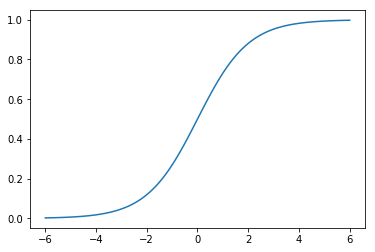

In [3]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

In [4]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, 
                  cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

In [18]:
y

array([1., 1., 0., ..., 0., 1., 1.])

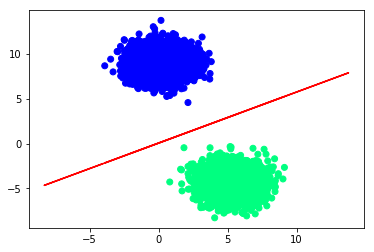

In [5]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. 20 points 

Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [16]:
@numba.vectorize([float64(float64)])
def logistic_numba_cpu(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))


In [28]:
@numba.vectorize([float64(float64)], target='parallel')
def logistic_numba_parallel(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

In [18]:
np.testing.assert_array_almost_equal(logistic(x), logistic_numba_cpu(x))

In [21]:
np.testing.assert_array_almost_equal(logistic(x), logistic_numba_parallel(x))

In [29]:
%timeit -r3 -n3 logistic(x)
%timeit -r3 -n3 logistic_numba_cpu(x)
%timeit -r3 -n3 logistic_numba_parallel(x)

16.8 µs ± 6.67 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
The slowest run took 4.40 times longer than the fastest. This could mean that an intermediate result is being cached.
2.89 µs ± 2.15 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
The slowest run took 4.80 times longer than the fastest. This could mean that an intermediate result is being cached.
386 µs ± 268 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [6]:
@jit
def logistic_numba(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

In [7]:
@jit
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

In [8]:
%timeit -r3 -n3 gd(X, y, β, α, niter)
%timeit -r3 -n3 gd_numba(X, y, β, α, niter)

291 ms ± 37.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
295 ms ± 60.4 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [10]:
func = gd_numba
print(np.allclose(gd_numba(X, y, β, α, niter), gd(X, y, β, α, niter)))
%timeit -r3 -n3 func(X, y, β, α, niter)

True
249 ms ± 4.86 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


**2**. 30 points 

Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [11]:
%load_ext Cython

In [12]:
%%cython -a
import cython
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def logistic_cython(long[:] x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

In [12]:
func = logistic_cython
print(np.allclose(logistic_cython(x),logistic(x)))
%timeit -r3 -n3 func(x)

True
19.8 µs ± 7.17 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [ ]:
def gd_cython(double[:, ::1] X, double[:] y, double[:] beta, double alpha, int niter):
    """Gradient descent algorihtm."""    
    cdef int n = X.shape[0]
    cdef int p = X.shape[1]
    cdef double[:] eps = np.empty(n)
    cdef double[:] y_pred = np.empty(n)
    cdef double[:] grad = np.empty(p)  
    cdef int i, j, k
    cdef double[:, :] Xt = X.T
    
    for i in range(niter):
        y_pred = logistic_(np.dot(X, beta))
        for j in range(n):
            eps[j] = y[j] - y_pred[j]
        grad = np.dot(Xt, eps) / n
        for k in range(p):
            beta[k] += alpha * grad[k]
    return beta

In [18]:
%%cython -a
import cython
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivison(True)
cdef long[:] logistic_cython(long[:] x):
    """Logistic function."""
    return exp(x)/(1 + exp(x))

def gd_cython(long[:,:] X, long[:] y, long[:] beta, float alpha, int niter):
    """Gradient descent algorihtm."""
    cdef int n, p
    n, p = X.shape
    cdef double[:] eps
    cdef double[:] grad
    cdef double[:] y_pred
    cdef double[:, :] Xt = X.T
    #Xt = X.T
    with cython.nogil:
        for i in range(niter):
            y_pred = logistic_cython(X @ beta)
            eps = y - y_pred
            grad = Xt @ eps / n
            beta += alpha * grad
    return beta


Error compiling Cython file:
------------------------------------------------------------
...
import cython
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivison(True)
^
------------------------------------------------------------

/Users/hannah/.ipython/cython/_cython_magic_1ffb6e5dd6b14b329d52078d8f5f6e83.pyx:6:0: Cdef functions/classes cannot take arbitrary decorators.


TypeError: object of type 'NoneType' has no len()

**3**. 25 points

Implement Newton's method in 1D for root finding. Pass in the function and gradient as generalized function pointers. Use the method to find all roots of the polynomial equation $f(x) = x^3 - 7x - 6$

In [22]:
def f(x):
    return x**2 -7*x-6

In [25]:
def fprime(x):
    return 2*x-7

In [19]:
def newton(z, f, fprime, max_iter=100, tol=1e-6):
    """iteratively apply newton-rhpason method till max_iter or abs func value below tol"""
    for i in range(max_iter):
        
        if abs(f(z))<tol:
            break
        else:
            z = z - f(z)/fprime(z)
    return i, z

In [ ]:
%%cython -a
import cython
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivison(True)

def newton_cython(z, f, fprime, max_iter=100, tol=1e-6):
    """iteratively apply newton-rhpason method till max_iter or abs func value below tol"""
    for i in range(max_iter):
        
        if abs(f(z))<tol:
            break
        else:
            z = z - f(z)/fprime(z)
    return i, z

**4**. 25 points

Use the `armadillo` or `eigen` library to

- Generate 10 x-coordinates linearly spaced between 10 and 15
- Generate 10 random y-values as $y = 3x^2 - 7x + 2 + \epsilon$ where $\epsilon \sim 10 N(0,1)$
- Find the length of $x$ and $y$ and the Euclidean distance between $x$ and $y$
- Find the correlation between $x$ and $y$
- Solve the linear system to find a quadratic fit for this data

In [56]:
%%file test_arma.cpp
#include <iostream>
#include <armadillo>

using namespace std;
using namespace arma;

int main()
  {
  vec x = linspace<vec>(10.0,15.0,10);
  vec e = 10*randn<vec>(10);
  vec y = 3*x%x - 7*x + 2 + e;

  cout << "x:" << x << endl;
  cout << "y:" << y << endl;
  cout<< "x length: "<< norm(x) << endl;
  cout<< "y length: "<< norm(x) << endl;
  cout<< "dist: "<< norm(x - y) << endl;
  cout<< "correlation: "<< cor(x - y) << endl;
  /*solve equation*/
  mat A = join_rows(x%x, x, ones<vec>(10));
  vec b = solve(A,y);
  cout<< "join row: "<< A<< endl;
  cout<< "coefficient: "<< b<< endl;
  }

Overwriting test_arma.cpp


In [57]:
%%bash

g++ -o test_arma.exe test_arma.cpp -std=c++14 -larmadillo

./test_arma.exe

x:   10.0000
   10.5556
   11.1111
   11.6667
   12.2222
   12.7778
   13.3333
   13.8889
   14.4444
   15.0000

y:   2.3990e+02
   2.5550e+02
   2.9554e+02
   3.3068e+02
   3.6181e+02
   4.0182e+02
   4.4484e+02
   4.6213e+02
   5.0999e+02
   5.7655e+02

x length: 39.8493
y length: 39.8493
dist: 1231.7
correlation:    1.0000

join row:    1.0000e+00   1.0000e+01   1.0000e+02
   1.0000e+00   1.0556e+01   1.1142e+02
   1.0000e+00   1.1111e+01   1.2346e+02
   1.0000e+00   1.1667e+01   1.3611e+02
   1.0000e+00   1.2222e+01   1.4938e+02
   1.0000e+00   1.2778e+01   1.6327e+02
   1.0000e+00   1.3333e+01   1.7778e+02
   1.0000e+00   1.3889e+01   1.9290e+02
   1.0000e+00   1.4444e+01   2.0864e+02
   1.0000e+00   1.5000e+01   2.2500e+02

coefficient:    1.1483e+02
  -2.3513e+01
   3.5703e+00

